In [12]:
# Importing necessary libraries
import deepxde as dde
from deepxde.backend import tf
import numpy as np

In [21]:
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [13]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [14]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2500, num_boundary=100, num_initial=100)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [15]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000324 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.98e-02, 2.59e-01, 2.18e-01]    [2.98e-02, 2.59e-01, 2.18e-01]    []  
1000      [4.01e-02, 3.49e-04, 5.40e-02]    [4.01e-02, 3.49e-04, 5.40e-02]    []  
2000      [3.19e-02, 3.45e-05, 4.72e-02]    [3.19e-02, 3.45e-05, 4.72e-02]    []  
3000      [2.54e-02, 9.09e-05, 3.85e-02]    [2.54e-02, 9.09e-05, 3.85e-02]    []  
4000      [8.03e-03, 2.37e-05, 9.86e-03]    [8.03e-03, 2.37e-05, 9.86e-03]    []  
5000      [3.21e-03, 6.89e-06, 2.51e-03]    [3.21e-03, 6.89e-06, 2.51e-03]    []  
6000      [2.42e-03, 6.45e-06, 1.85e-03]    [2.42e-03, 6.45e-06, 1.85e-03]    []  
7000      [2.06e-03, 4.49e-06, 1.56e-03]    [2.06e-03, 4.49e-06, 1.56e-03]    []  
8000      [1.67e-03, 3.53e-06, 1.28e-03]    [1.67e-03, 3.53e-06, 1.28e-03]    []  
9000      [1.37e-03, 3.24e-06, 1.12e-03]    [1.37e-03, 3.24e-06, 1.12e-03]    []  
10000     [1.15

In [16]:
X = geomtime.random_points(100000)
err = 1

In [17]:
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Mean residual: 4.251e-03
Adding new point: [0.00274169 0.45199165] 

Compiling model...
'compile' took 0.000098 s

Training model...

Step      Train loss                        Test loss                         Test metric
25000     [3.41e-03, 1.76e-08, 3.13e-07]    [4.15e-06, 1.76e-08, 3.13e-07]    []  
26000     [5.42e-05, 6.08e-08, 1.35e-05]    [5.27e-05, 6.08e-08, 1.35e-05]    []  
27000     [2.65e-05, 2.99e-08, 6.51e-06]    [2.58e-05, 2.99e-08, 6.51e-06]    []  
28000     [1.80e-05, 1.70e-08, 4.07e-06]    [1.80e-05, 1.70e-08, 4.07e-06]    []  
Epoch 28000: early stopping

Best model at step 28000:
  train loss: 2.21e-05
  test loss: 2.21e-05
  test metric: []

'train' took 17.382432 s

Compiling model...
'compile' took 0.000096 s

Training model...

Step      Train loss                        Test loss                         Test metric
28000     [1.80e-05, 1.70e-08, 4.07e-06]    [1.80e-05, 1.70e-08, 4.07e-06]    []  
29000     [5.41e-06, 1.77e-08, 6.18e-07]    [5.41e-06, 1.77e-

Saving loss history to d:\GitHub\uis-pinns-research\loss.dat ...
Saving training data to d:\GitHub\uis-pinns-research\train.dat ...
Saving test data to d:\GitHub\uis-pinns-research\test.dat ...


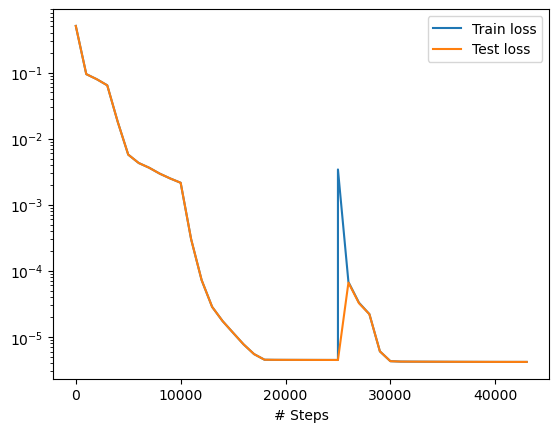

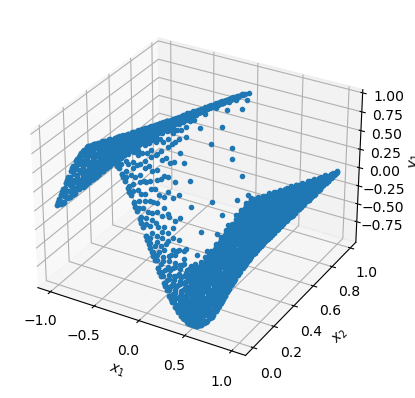

L2 relative error: 0.0059667539553806895


In [22]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))